$$
\newcommand{\ind}{{\bf 1}}
$$
This notebooks shows how to simulate a 4-factor Markov PDV as described in [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4174589).

We describe below the model with the extension of a parabolic term:
$$
        \frac{dS_t}{S_t} = \sigma_t dW_t, \; \\
        \sigma_t = \beta_0 + \beta_1 R_{1,t} + \beta_2 \sqrt{R_{2,t}} + \beta_{1,2} R_{1}^2{\bf 1}_{R_1\geq c}, \; \\
        R_{i,t} = (1-\theta_i) R_{i,0,t} + \theta_i R_{i,1,t}, i\in\{1,2\}, \; \\
        dR_{1,j,t} = \lambda_{1,j} (\sigma_t dW_t - R_{1,j,t}), j\in \{0,1\}, \; \\
        dR_{2,j,t} = \lambda_{2,j}  (\sigma_t^2 dt - R_{2,j,t}), j\in \{0,1\}, \;
$$

In [2]:
from calibration.torch_montecarlo import TorchMonteCarloExponentialModel
from empirical_learning.plot_functions import *
import pandas as pd
import torch

In [3]:
# Defines model parameters and initial values. Those initial values should be computed using historical prices
lam1 = torch.tensor([80, 10])
lam2 = torch.tensor([40, 3.])
betas = torch.tensor([0.04, -0.1, 0.6])
R_init1 = torch.tensor([-0.10392006, 0.05214729])
R_init2 = torch.tensor([0.00655017, 0.01580152])
theta1 = 0.43
theta2 = 0.21
parabolic = 0 # beta_12
parabolic_offset = 0  # c

In [4]:
# Simulation parameters
N = 10000 # number of paths 
vix_N = 1000 # number of subpaths for VIX computation
timestep_per_day = 5 # number of timestep per business day
maturity = 0.5 #maturity in years.

In [5]:
# Simulation. If you have access to a gpu, replace device='cpu' by device='cuda'. It can significanly speedup VIX computation.
torch_mc = TorchMonteCarloExponentialModel(lam1=lam1, lam2=lam2, betas=betas, R_init1=R_init1, R_init2=R_init2,
                                        theta1=theta1, theta2=theta2, N=N, vix_N=vix_N, maturity=maturity, parabolic=0, parabolic_offset=0,
                                          device='cpu')
torch_mc.simulate()

In [6]:
torch_mc.R1_array.shape

torch.Size([631, 2, 10000])

In [7]:
# Computes SPX implied volatilies and vanilla call prices
option_maturity = 1/12 # maturity of the option in years
strikes = np.arange(0.9, 1.05, 0.01) # strikes
future, _, implied_vol, option_prices = torch_mc.compute_implied_vol(strikes=strikes, option_maturity=option_maturity)

Text(0.5, 0, 'strike')

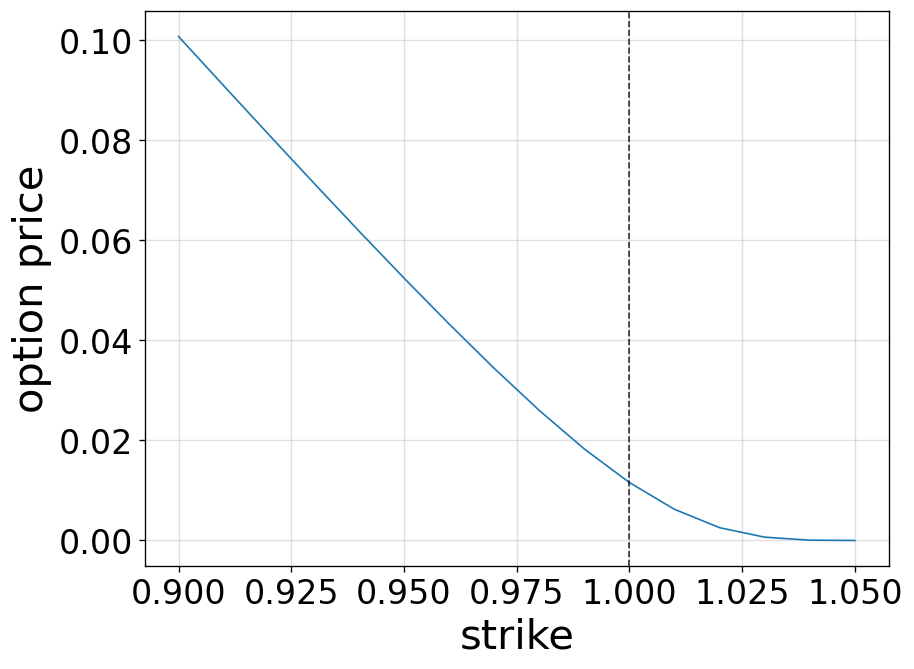

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(strikes, option_prices)
ax.axvline(x=future, linestyle='--', color='k', alpha=0.8)
ax.set_ylabel('option price')
ax.set_xlabel('strike')

Text(0.5, 0, 'strike')

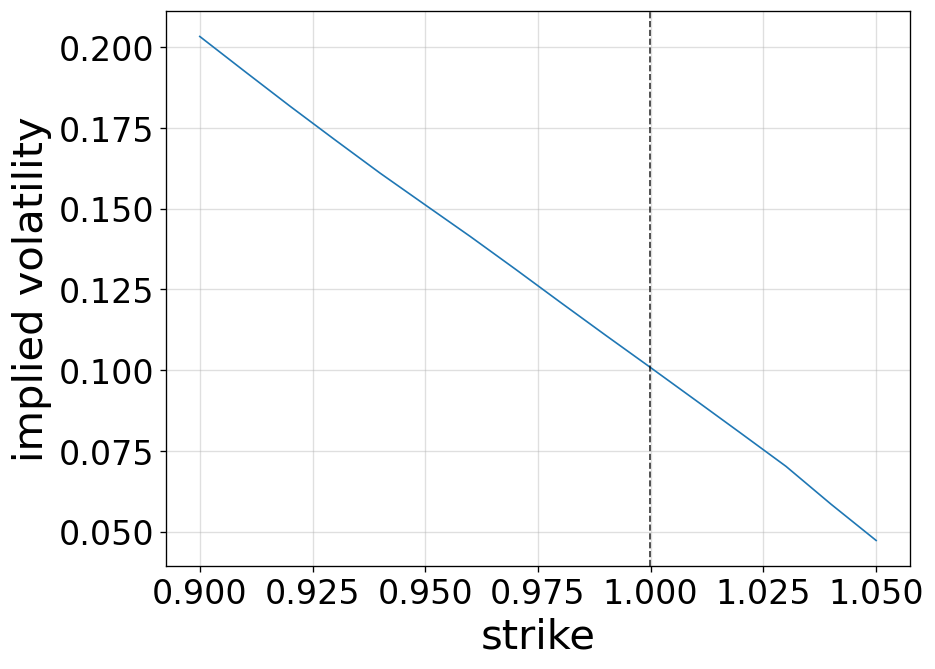

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(strikes, implied_vol)
ax.axvline(x=future, linestyle='--', color='k', alpha=0.8)
ax.set_ylabel('implied volatility')
ax.set_xlabel('strike')

In [11]:
# Can take up to 3-5 minutes to run.
# Compute VIX future, call prices and implied volatilities.
vix_strikes = None # If None, the strikes will be from 0.7 * future to 1.5 * future
vix_future, vix_strikes, vix_implied_vol, vix_option_price = torch_mc.compute_vix_implied_vol(vix_maturity=option_maturity, strikes=vix_strikes)

Text(0.5, 0, 'Strike')

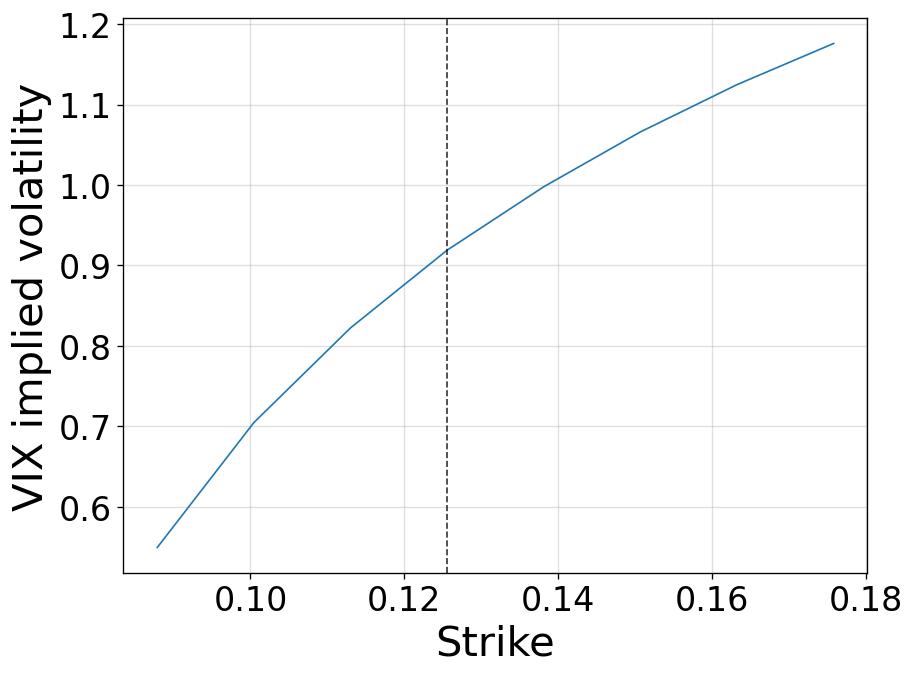

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(vix_strikes, vix_implied_vol)
ax.axvline(x=vix_future, linestyle='--', color='k', alpha=0.8)
ax.set_ylabel('VIX implied volatility')
ax.set_xlabel('Strike')